In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union, nearest_points
from shapely import wkt

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
from my_osm import get_osm_data
from my_area_stats import val_per_area

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'The Hague'
country = 'NLD'
sub_folder = str(place_name).replace(' ', '')+'_14Apr2022'
local_crs = 'EPSG:28992'
place_extra = 0

In [5]:
trip_distances = [300, 500, 800]
buffer = max(trip_distances)

tolerance = 20
children = True
detours = True
osm_schools = False

preprocessed = True

# Load data

In [6]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)
if place_extra:
    place['geometry'] = place.buffer(place_extra, join_style=2)
extent = place.buffer(buffer, join_style=2)

## DUO Dutch Educational

In [7]:
# https://www.duo.nl/open_onderwijsdata/primair-onderwijs/scholen-en-adressen/#

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
geolocator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [10]:
if country == 'NLD':
    folder = os.path.join('data', 'education', 'NLD')

In [11]:
def format_query(row, postalcode_only=False):
    # query containing only postal code, and country
    if postalcode_only:
        return {
            'postalcode': row['POSTCODE'].replace(' ', ''),
            'country': 'NL'        
        }
    
    # query containing street and house number (without addition), postal code, place name, and country
    else:
        # some places have province abbreviations at their end, omit that part
        provinces = (' ZH', ' NH', ' FR', ' GN', ' GLD', ' ZLD', ' DR', ' LB', ' L' ' NB', 'UT', 'OV')   # FL for Flevoland?
        if row['PLAATSNAAM'].endswith(provinces):
            plaatsnaam = row['PLAATSNAAM'].split(' ')[:-1]
            plaatsnaam = ' '.join(plaatsnaam)
        else:
            plaatsnaam = row['PLAATSNAAM']

        # some places have a municipality (GEM) defined, omit that part
        return {
            'street': row['STRAATNAAM'] + ' ' + str(row['HUISNUMMER-TOEVOEGING']).split('-')[0],
            'postalcode': row['POSTCODE'].replace(' ', ''),
            'city': plaatsnaam.split(' GEM ')[0],
            'country': 'NL'        
        }

In [12]:
def get_edu_geocodes(gdf, postalcode_only=False):
    
    gdf['query'] = gdf.apply(lambda row: format_query(row, postalcode_only=postalcode_only), axis=1)   
    gdf['location'] = gdf['query'].apply(geocode)
    gdf['geometry'] = gdf['location'].apply(lambda loc: tuple(loc.point) if loc else None)
    
    return gdf

In [13]:
def geocodes_to_gdf(gdf):

    gdf.crs = 'epsg:4326'
    gdf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(gdf['geometry'].tolist(), index=gdf.index)
    gdf['geometry'] = [Point(xy) for xy in zip(gdf.longitude, gdf.latitude)] 
    gdf = gdf.to_crs(local_crs)
    
    return gdf

## Primary schools (basisonderwijs)

In [14]:
if not preprocessed:
    primary = gpd.read_file(os.path.join(folder, '02-alle-schoolvestigingen-basisonderwijs.csv'))
    primary_enriched = get_edu_geocodes(primary)
    primary_output = primary_enriched[primary_enriched['location'].notna()]
    primary_gdf = geocodes_to_gdf(primary_output)

In [15]:
if not preprocessed:
    if len(primary_enriched[primary_enriched['location'].isna()]) > 0:
        primary_iteration = primary_enriched[primary_enriched['location'].isna()]
        primary_iteration_enriched = get_edu_geocodes(primary_iteration, postalcode_only=True)
        primary_iteration_output = primary_iteration_enriched[primary_iteration_enriched['location'].notna()]
        primary_iteration_gdf = geocodes_to_gdf(primary_iteration_output)
        primary_total = gpd.GeoDataFrame(pd.concat([primary_gdf, primary_iteration_gdf], ignore_index=True))
    else:
        primary_total = primary_gdf.copy()

In [16]:
if not preprocessed:
    if len(primary_total) != len(primary):      
        not_found = list(set(primary['VESTIGINGSNUMMER'].unique()) - set(primary_total['VESTIGINGSNUMMER'].unique()))
        for nr in not_found:
            row = primary[primary['VESTIGINGSNUMMER']==nr]
            primary_total = gpd.GeoDataFrame(pd.concat([primary_total, row], ignore_index=True))
        print('{} geocoordinates could not be identified'.format(len(not_found)))

In [17]:
if not preprocessed:
    primary_total.to_csv(os.path.join(folder, 'primary_enriched.csv'))

In [18]:
if preprocessed:
    df = pd.read_csv(os.path.join(folder, 'primary_enriched.csv'))
    df.loc[df['geometry'].isna()] = 'Point Empty'
    df['geometry'] = df['geometry'].apply(wkt.loads)
    primary_total = gpd.GeoDataFrame(df, crs=local_crs)  

## Secondary schools (voortgezet onderwijs)

In [19]:
if not preprocessed:
    secondary = gpd.read_file(os.path.join(folder, '02-alle-vestigingen-vo.csv'))
    secondary_enriched = get_edu_geocodes(secondary)
    secondary_output = secondary_enriched[secondary_enriched['location'].notna()]
    secondary_gdf = geocodes_to_gdf(secondary_output)

In [20]:
if not preprocessed:
    if len(secondary_enriched[secondary_enriched['location'].isna()]) > 0:
        secondary_iteration = secondary_enriched[secondary_enriched['location'].isna()]
        secondary_iteration_enriched = get_edu_geocodes(secondary_iteration, postalcode_only=True)
        secondary_iteration_output = secondary_iteration_enriched[secondary_iteration_enriched['location'].notna()]
        secondary_iteration_gdf = geocodes_to_gdf(secondary_iteration_output)
        secondary_total = gpd.GeoDataFrame(pd.concat([secondary_gdf, secondary_iteration_gdf], ignore_index=True))
    else:
        secondary_total = secondary_gdf.copy()

In [21]:
if not preprocessed:
    if len(secondary_total) != len(secondary):
        not_found = list(set(secondary['VESTIGINGSNUMMER'].unique()) - set(secondary_total['VESTIGINGSNUMMER'].unique()))
        for nr in not_found:
            row = secondary[secondary['VESTIGINGSNUMMER']==nr]
            secondary_total = gpd.GeoDataFrame(pd.concat([secondary_total, row], ignore_index=True))
        print('{} geocoordinates could not be identified'.format(len(not_found)))

In [22]:
if not preprocessed:
    secondary_total.to_csv(os.path.join(folder, 'secondary_enriched.csv'))

In [23]:
if preprocessed:
    df = pd.read_csv(os.path.join(folder, 'secondary_enriched.csv'))
    df.loc[df['geometry'].isna()] = 'Point Empty'
    df['geometry'] = df['geometry'].apply(wkt.loads)
    secondary_total = gpd.GeoDataFrame(df, crs=local_crs)        

## Higher education (MBO)

In [24]:
if not preprocessed:
    mbo = gpd.read_file(os.path.join(folder, '01-adressen-instellingen.csv'))
    mbo_enriched = get_edu_geocodes(mbo)
    mbo_output = mbo_enriched[mbo_enriched['location'].notna()]
    mbo_gdf = geocodes_to_gdf(mbo_output)

In [25]:
if not preprocessed:
    if len(mbo_enriched[mbo_enriched['location'].isna()]) > 0:
        mbo_iteration = mbo_enriched[mbo_enriched['location'].isna()]
        mbo_iteration_enriched = get_edu_geocodes(mbo_iteration, postalcode_only=True)
        mbo_iteration_output = mbo_iteration_enriched[mbo_iteration_enriched['location'].notna()]
        mbo_iteration_gdf = geocodes_to_gdf(mbo_iteration_output)
        mbo_total = gpd.GeoDataFrame(pd.concat([mbo_gdf, mbo_iteration_gdf], ignore_index=True))
    else:
        mbo_total = mbo_gdf.copy()

In [26]:
if not preprocessed:
    if len(mbo_total) != len(mbo):        
        not_found = list(set(mbo['VESTIGINGSNUMMER'].unique()) - set(mbo_total['VESTIGINGSNUMMER'].unique()))
        for nr in not_found:
            row = mbo[mbo['VESTIGINGSNUMMER']==nr]
            mbo_total = gpd.GeoDataFrame(pd.concat([mbo_total, row], ignore_index=True))
        print('{} geocoordinates could not be identified'.format(len(not_found)))

In [27]:
if not preprocessed:
    mbo_total.to_csv(os.path.join(folder, 'mbo_enriched.csv'))

In [28]:
if preprocessed:
    df = pd.read_csv(os.path.join(folder, 'mbo_enriched.csv'))
    df.loc[df['geometry'].isna()] = 'Point Empty'
    df['geometry'] = df['geometry'].apply(wkt.loads)
    mbo_total = gpd.GeoDataFrame(df, crs=local_crs)     

## Higher education (HBO, WO)

In [29]:
if not preprocessed:
    hbowo = gpd.read_file(os.path.join(folder, '01-instellingen-hbo-en-wo.csv'))
    hbowo_enriched = get_edu_geocodes(hbowo)
    hbowo_output = hbowo_enriched[hbowo_enriched['location'].notna()]
    hbowo_gdf = geocodes_to_gdf(hbowo_output)

In [30]:
if not preprocessed:
    if len(hbowo_enriched[hbowo_enriched['location'].isna()]) > 0:
        hbowo_iteration = hbowo_enriched[hbowo_enriched['location'].isna()]
        hbowo_iteration_enriched = get_edu_geocodes(hbowo_iteration, postalcode_only=True)
        hbowo_iteration_output = hbowo_iteration_enriched[hbowo_iteration_enriched['location'].notna()]
        hbowo_iteration_gdf = geocodes_to_gdf(hbowo_iteration_output)
        hbowo_total = gpd.GeoDataFrame(pd.concat([hbowo_gdf, hbowo_iteration_gdf], ignore_index=True))
    else:
        hbowo_total = hbowo_gdf.copy()

In [31]:
if not preprocessed:
    if len(hbowo_total) != len(hbowo):
        not_found = list(set(hbowo['VESTIGINGSNUMMER'].unique()) - set(hbowo_total['VESTIGINGSNUMMER'].unique()))
        for nr in not_found:
            row = hbowo[hbowo['VESTIGINGSNUMMER']==nr]
            hbowo_total = gpd.GeoDataFrame(pd.concat([hbowo_total, row], ignore_index=True))
        print('{} geocoordinates could not be identified'.format(len(not_found)))

In [32]:
if not preprocessed:
    hbowo_total.to_csv(os.path.join(folder, 'hbowo_enriched.csv'))

In [33]:
if preprocessed:
    df = pd.read_csv(os.path.join(folder, 'hbowo_enriched.csv'))
    df.loc[df['geometry'].isna()] = 'Point Empty'
    df['geometry'] = df['geometry'].apply(wkt.loads)
    hbowo_total = gpd.GeoDataFrame(df, crs=local_crs)     

## Higher education (PABO)

In [34]:
if not preprocessed:
    pabo = gpd.read_file(os.path.join(folder, '02-instellingen-pabo.csv'))
    pabo_enriched = get_edu_geocodes(pabo)
    pabo_output = pabo_enriched[pabo_enriched['location'].notna()]
    pabo_gdf = geocodes_to_gdf(pabo_output)

In [35]:
if not preprocessed:
    if len(pabo_enriched[pabo_enriched['location'].isna()]) > 0:
        pabo_iteration = pabo_enriched[pabo_enriched['location'].isna()]
        pabo_iteration_enriched = get_edu_geocodes(pabo_iteration, postalcode_only=True)
        pabo_iteration_output = pabo_iteration_enriched[pabo_iteration_enriched['location'].notna()]
        pabo_iteration_gdf = geocodes_to_gdf(pabo_iteration_output)
        pabo_total = gpd.GeoDataFrame(pd.concat([pabo_gdf, pabo_iteration_gdf], ignore_index=True))
    else:
        pabo_total = pabo_gdf.copy()

In [36]:
if not preprocessed:
    if len(pabo_total) != len(pabo):
        not_found = list(set(pabo['VESTIGINGSNUMMER'].unique()) - set(pabo_total['VESTIGINGSNUMMER'].unique()))
        for nr in not_found:
            row = pabo[pabo['VESTIGINGSNUMMER']==nr]
            pabo_total = gpd.GeoDataFrame(pd.concat([pabo_total, row], ignore_index=True))
        print('{} geocoordinates could not be identified'.format(len(not_found)))

In [37]:
if not preprocessed:
    pabo_total.to_csv(os.path.join(folder, 'pabo_enriched.csv'))

In [38]:
if preprocessed:
    df = pd.read_csv(os.path.join(folder, 'pabo_enriched.csv'))
    df.loc[df['geometry'].isna()] = 'Point Empty'
    df['geometry'] = df['geometry'].apply(wkt.loads)
    pabo_total = gpd.GeoDataFrame(df, crs=local_crs)     

## Special education

In [39]:
if not preprocessed:
    special = gpd.read_file(os.path.join(folder, '09-alle-vestigingen-sbo-so-en-vso.csv'))
    special_enriched = get_edu_geocodes(special)
    special_output = special_enriched[special_enriched['location'].notna()]
    special_gdf = geocodes_to_gdf(special_output)

In [40]:
if not preprocessed:
    if len(special_enriched[special_enriched['location'].isna()]) > 0:
        special_iteration = special_enriched[special_enriched['location'].isna()]
        special_iteration_enriched = get_edu_geocodes(special_iteration, postalcode_only=True)
        special_iteration_output = special_iteration_enriched[special_iteration_enriched['location'].notna()]
        special_iteration_gdf = geocodes_to_gdf(special_iteration_output)
        special_total = gpd.GeoDataFrame(pd.concat([special_gdf, special_iteration_gdf], ignore_index=True))
    else:
        special_total = special_gdf.copy()

In [41]:
if not preprocessed:
    if len(special_total) != len(special):
        not_found = list(set(special['VESTIGINGSNUMMER'].unique()) - set(special_total['VESTIGINGSNUMMER'].unique()))
        for nr in not_found:
            row = special[special['VESTIGINGSNUMMER']==nr]
            special_total = gpd.GeoDataFrame(pd.concat([special_total, row], ignore_index=True))
        print('{} geocoordinates could not be identified'.format(len(not_found)))

In [42]:
if not preprocessed:
    special_total.to_csv(os.path.join(folder, 'special_enriched.csv'))

In [43]:
if preprocessed:
    df = pd.read_csv(os.path.join(folder, 'special_enriched.csv'))
    df.loc[df['geometry'].isna()] = 'Point Empty'
    df['geometry'] = df['geometry'].apply(wkt.loads)
    special_total = gpd.GeoDataFrame(df, crs=local_crs)     

### OpenStreetMap

In [44]:
# https://wiki.openstreetmap.org/wiki/Education_features

In [45]:
if osm_schools:
    kindergarten_query = '["amenity"~"^(kindergarten)"]'
    kindergartens = get_osm_data(kindergarten_query, extent, 'convexhull')
    kindergartens['category'] = 'kindergarten'
    
    school_query = '["amenity"~"^(school)"]'
    schools = get_osm_data(school_query, extent, 'convexhull')
    schools['category'] = 'school'

In [46]:
college_query = '["amenity"~"^(college)"]'
colleges = get_osm_data(college_query, extent, 'convexhull')
colleges['category'] = 'college'

university_query = '["amenity"~"^(university)"]'
universities = get_osm_data(university_query, extent, 'convexhull')
universities['category'] = 'university'

### Combine and clip to extents

In [47]:
education_children = gpd.clip(primary_total, extent)

In [48]:
list_dest_adl = [secondary_total, colleges, universities]
education_adolescents = gpd.GeoDataFrame(pd.concat(list_dest_adl, ignore_index=True))
education_adolescents['original_geometry'] = education_adolescents.geometry
education_adolescents = education_adolescents.set_geometry(education_adolescents.geometry.centroid)
education_adolescents = gpd.clip(education_adolescents, extent)

## Plot all

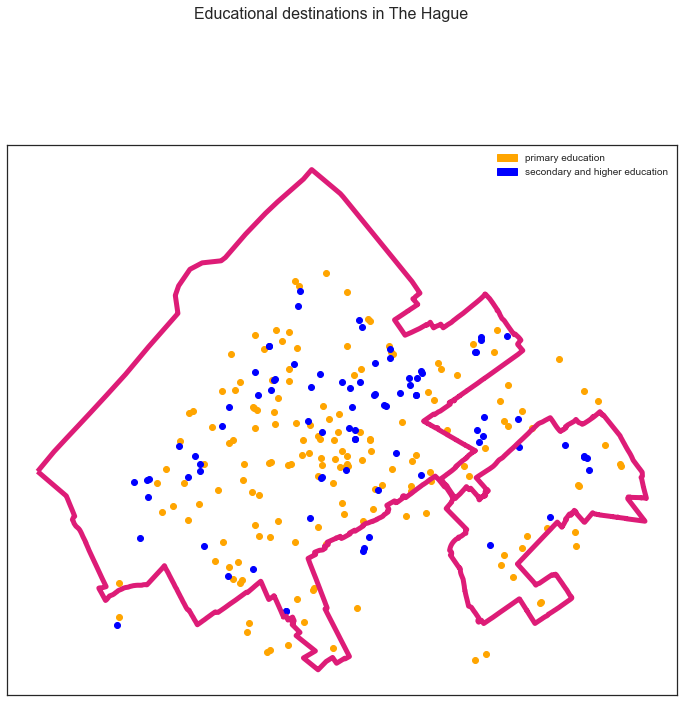

In [49]:
handles = [
    mpatches.Patch(color='orange', label='primary education'),
    mpatches.Patch(color='blue', label='secondary and higher education')]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12,12))
fig.suptitle('Educational destinations in {}'.format(place_name), fontsize=16)

education_children.plot(ax=axs, color='orange')
education_adolescents.plot(ax=axs, color='blue')

place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=4)

axs.axes.get_xaxis().set_visible(False)
axs.axes.get_yaxis().set_visible(False)
axs.legend(handles=handles)

plt.show()

In [50]:
len(education_children)

164

In [51]:
len(education_adolescents)

85

#  Store output data

In [52]:
output_sub_folder = os.path.join(output_folder, sub_folder)

In [53]:
output_file = os.path.join(output_sub_folder, 'education_children.geojson')
education_children = education_children.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
education_children.to_file(output_file, driver='GeoJSON')

In [54]:
output_file = os.path.join(output_sub_folder, 'education_adolescents.geojson')
education_adolescents = education_adolescents.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
education_adolescents.to_file(output_file, driver='GeoJSON')